In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob




In [2]:
def process_data(env_path):
    data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
        if len(data_set) < min_size:
            min_size = len(data_set)
        data.append(data_set)
    data = np.stack([d[:min_size] for d in data])
    mean = np.mean(data, axis=0)
    std  = np.std(data, axis=0)
    data_log = {'x' : mean[:,0], 'mean' : mean[:,1], 'std' : std[:,1]}
    return data_log

def plot_data(log, label, color):
    plt.plot(log['x'], log['mean'], label=label, color=color)
    plt.fill_between(log['x'], 
                    log['mean']-log['std']*0.95, log['mean']+log['std']*0.95,
                    alpha=0.2, color=color)


In [3]:
hybrid_data = process_data('./examples/data/PendulumEnv/')
sac_data = process_data('./benchmark_examples/data/PendulumEnv/')

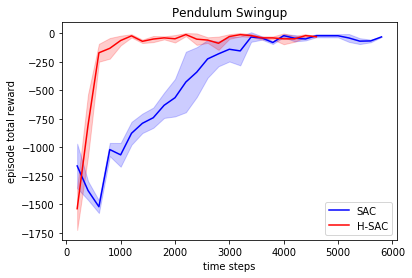

In [4]:
plot_data(sac_data, 'SAC', 'b')
plot_data(hybrid_data, 'H-SAC', 'r')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()


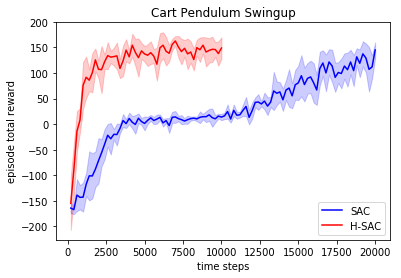

In [5]:
hybrid_data = process_data('./examples/data/InvertedPendulumSwingupBulletEnv/')
sac_data = process_data('./benchmark_examples/data/InvertedPendulumSwingupBulletEnv/')

plot_data(sac_data, 'SAC', 'b')
plot_data(hybrid_data, 'H-SAC', 'r')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Cart Pendulum Swingup')

plt.legend()

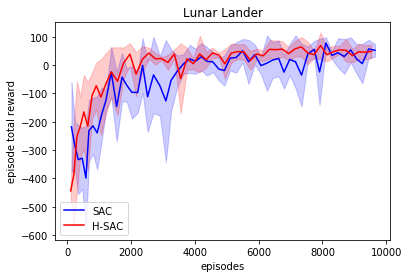

In [6]:
hybrid_data = process_data('./examples/data/LunarLanderContinuousEnv/')
sac_data = process_data('./benchmark_examples/data/LunarLanderContinuousEnv/')

plot_data(sac_data, 'SAC', 'b')
plot_data(hybrid_data, 'H-SAC', 'r')

# plt.plot(sac_data[1][:,0], sac_data[1][:,1])

# plt.plot(hybrid_data[1][:,0], hybrid_data[1][:,1])

plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.legend()

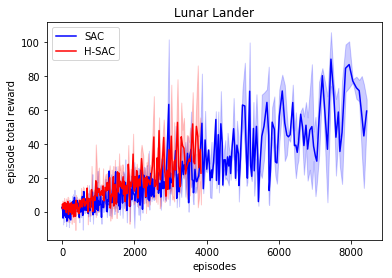

In [55]:
hybrid_data = process_data('./examples/data/HopperBulletEnv/')
sac_data = process_data('./benchmark_examples/data/HopperBulletEnv/')

plot_data(sac_data, 'SAC', 'b')
plot_data(hybrid_data, 'H-SAC', 'r')

# plt.plot(hybrid_data[0].T)

plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.legend()

In [141]:
mean_hs_data = np.mean(hybridsac_data, axis=0)
std_hs_data  = np.std(hybridsac_data, axis=0)

In [15]:
benchmarksac_data = []
min_size = np.inf
for path in glob.glob('./benchmark_examples/data/InvertedPendulumSwingupBulletEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    benchmarksac_data.append(data)


In [16]:
benchmarksac_data = np.stack([data[:min_size] for data in benchmarksac_data])

In [17]:
mean_bms_data = np.mean(benchmarksac_data, axis=0)
std_bms_data  = np.std(benchmarksac_data, axis=0)

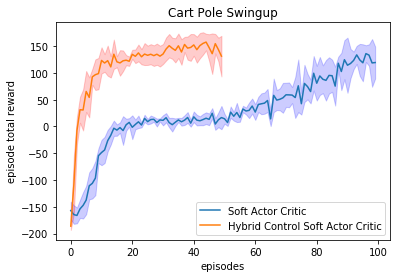

In [18]:
plt.plot(mean_bms_data, label='Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_bms_data))], 
                mean_bms_data-std_bms_data*0.95, mean_bms_data+std_bms_data*0.95,
                alpha=0.2, color='b')

plt.plot(mean_hs_data, label='Hybrid Control Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_hs_data))], 
                mean_hs_data-std_hs_data*0.95, mean_hs_data+std_hs_data*0.95,
                alpha=0.2, color='r')
plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Cart Pole Swingup')

plt.legend()

# plt.savefig('lunar_lander.png')

In [21]:
hybridsac_data = []
min_size = np.inf
for path in glob.glob('./examples/data/LunarLanderContinuousEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    hybridsac_data.append(data)

In [22]:
hybridsac_data = np.stack([data[:min_size] for data in hybridsac_data])

In [23]:
mean_hs_data = np.mean(hybridsac_data, axis=0)
std_hs_data  = np.std(hybridsac_data, axis=0)

In [24]:
benchmarksac_data = []
min_size = np.inf
for path in glob.glob('./benchmark_examples/data/LunarLanderContinuousEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    benchmarksac_data.append(data)


In [25]:
benchmarksac_data = np.stack([data[:min_size] for data in benchmarksac_data])

In [26]:
mean_bms_data = np.mean(benchmarksac_data, axis=0)
std_bms_data  = np.std(benchmarksac_data, axis=0)

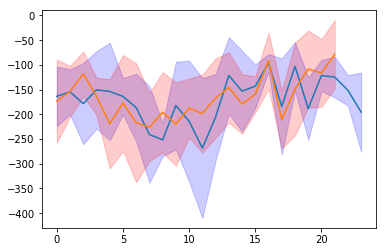

In [27]:
plt.plot(mean_bms_data, label='Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_bms_data))], 
                mean_bms_data-std_bms_data*0.95, mean_bms_data+std_bms_data*0.95,
                alpha=0.2, color='b')

plt.plot(mean_hs_data, label='Hybrid Control Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_hs_data))], 
                mean_hs_data-std_hs_data*0.95, mean_hs_data+std_hs_data*0.95,
                alpha=0.2, color='r')